
# Orientation-Triage Sequence Analysis

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from notebook_utils import NotebookUtilities
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 113)



## Do files switch back and forth between the orientation and normal training?

In [4]:

# Visualize the scene type sequence in each file by looping through
# each unique file and scene combination and recording the sequence
time_groups_dict = {}
for file_name, file_df in frvrs_logs_df.groupby('file_name'):
    key = file_name
    actions_list = []
    for scene_index, scene_df in file_df.sort_values('scene_index').groupby('scene_index'):
        scene_type = scene_df.scene_type.unique().item()
        actions_list.append(scene_type)
    time_groups_dict[key] = actions_list
color_dict = {'Orientation': '#1f77b4', 'Triage': '#ff7f0e'}

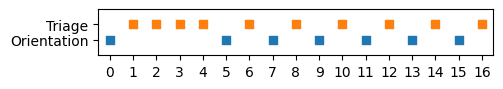

In [5]:

# Plot the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
fig = nu.plot_sequence(sequence, color_dict=color_dict, verbose=False)

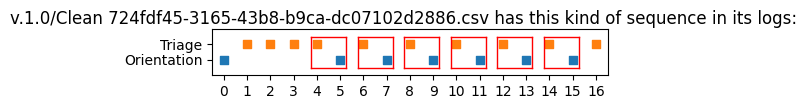

In [6]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['Triage', 'Orientation']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: nu.count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]
for k, v in time_groups_dict.items():
    if v == sequence: fig = nu.plot_sequence(
        sequence, highlighted_ngrams=highlighted_ngrams, suptitle=f'{k} has this kind of sequence in its logs:', color_dict=color_dict, verbose=False
    )

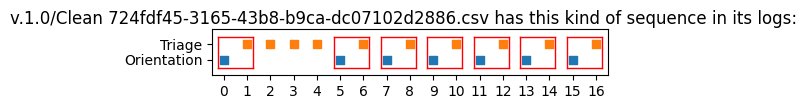

In [7]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['Orientation', 'Triage']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: nu.count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]
for k, v in time_groups_dict.items():
    if v == sequence: fig = nu.plot_sequence(
        sequence, highlighted_ngrams=highlighted_ngrams, suptitle=f'{k} has this kind of sequence in its logs:', color_dict=color_dict, verbose=False
    )

In [10]:

from pysan.multi import plot_sequences

count = 2
still_bombing = True
while still_bombing:
    
    # Get sequences from the consecutive time groups dictionary
    try:
        sequences = nu.get_sequences_by_count(consecutive_time_groups_dict, count=count)
        still_bombing = False
    except: count += 1

# Plot the time group sequences side-by-side
plot_sequences(sequences);

KeyboardInterrupt: 

In [11]:

count

68710459

In [60]:

def plot_sequences(sequences, gap=True):
    '''
    Creates a scatter style sequence plot for a collection of sequences.
    '''
    max_sequence_length = max([len(s) for s in sequences])
    plt.figure(figsize=[max_sequence_length*0.3,0.3 * len(sequences)])

    for y,sequence in enumerate(sequences):
        np_sequence = np.array(sequence)
        alphabet_len = len(get_alphabet(sequence))

        plt.gca().set_prop_cycle(None)
        unique_values = get_alphabet(sequence)
        for i, value in enumerate(unique_values):

            if gap:
                points = np.where(np_sequence == value, y + 1, np.nan)
                plt.scatter(x=range(len(np_sequence)), y=points, marker='s', label=value, s=100)
            else:
                points = np.where(np_sequence == value, 1, np.nan)
                plt.bar(range(len(points)), points, bottom=[y for x in range(len(points))], width=1, align='edge', label=value)

    if gap:
        plt.ylim(0.4, len(sequences) + 0.6)
        plt.xlim(-0.6, max_sequence_length - 0.4)
    else:
        plt.ylim(0,len(sequences))
        plt.xlim(0,max_sequence_length)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.1), loc='upper left')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        labelleft=False)

    return plt